In [1]:
DATAPATH = '../data/'
XFERPATH = '~/gdrive_files/twitgen/'  # To transfer files from Google Colab
TRAIN_FNAME = 'embed_train_201906020021.csv'
VALID_FNAME = 'embed_valid_201906020021.csv'
TEST_FNAME = 'embed_test_201906020021.csv'

In [2]:
train_from = XFERPATH + TRAIN_FNAME
valid_from = XFERPATH + VALID_FNAME
test_from = XFERPATH + TEST_FNAME
!cp $train_from $DATAPATH
!cp $valid_from $DATAPATH
!cp $test_from $DATAPATH

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [4]:
df_train = pd.read_csv(DATAPATH+TRAIN_FNAME, index_col=[0,1], parse_dates=['time'])
df_valid = pd.read_csv(DATAPATH+VALID_FNAME, index_col=[0,1], parse_dates=['time'])
df_test = pd.read_csv(DATAPATH+TEST_FNAME, index_col=[0,1], parse_dates=['time'])
df_train.head().iloc[:,:7]

,,male,embed0,embed1,embed2,embed3,embed4,embed5
id,time,,,,,,,
1083596943807393792,2019-05-27 23:27:08+00:00,True,-14081,80216,26727,19969,-5932,14983
815783987784187904,2019-05-24 15:36:01+00:00,False,-8092,-61741,24805,-21488,-20012,6800
3458239641,2019-05-24 19:00:37+00:00,False,-47872,-23766,28058,63213,9773,31955
1003729876250226688,2019-05-26 12:53:00+00:00,True,-16403,68003,17321,110208,4481,-44518
2360143940,2019-05-28 03:50:46+00:00,False,-11004,-11367,-47373,58910,31987,-48830


In [5]:
print(df_train.shape, df_valid.shape, df_test.shape)
print(df_train.index.get_level_values(1).min(), df_train.index.get_level_values(1).max())
print(df_valid.index.get_level_values(1).min(), df_valid.index.get_level_values(1).max())
print(df_test.index.get_level_values(1).min(), df_test.index.get_level_values(1).max())

(34146, 513) (10914, 513) (10450, 513)
2019-05-21 17:50:48+00:00 2019-05-28 12:44:26+00:00
2019-05-28 12:44:27+00:00 2019-05-30 12:09:54+00:00
2019-05-30 12:10:02+00:00 2019-06-01 19:55:43+00:00


In [6]:
def getxy(df):
    X = df.drop(['male'],axis=1).values / 1e6
    y = 1*df.male.values
    return(X, y)
    
X_train, y_train = getxy(df_train)
X_valid, y_valid = getxy(df_valid)
X_test, y_test = getxy(df_test)

In [7]:
pca = PCA(64)
pca.fit(X_train)
print(pca.explained_variance_ratio_)

[0.07026239 0.04059233 0.03006268 0.02582044 0.02315705 0.02282998
 0.02029119 0.01950688 0.01811937 0.01759093 0.01698417 0.01581307
 0.01501543 0.0143409  0.0140565  0.0136094  0.01326289 0.01279029
 0.01203898 0.0119673  0.01169786 0.01145497 0.01104007 0.01083215
 0.01029427 0.01027465 0.009769   0.00968524 0.00925612 0.009035
 0.00875647 0.00859185 0.00853061 0.00833646 0.00826678 0.00796735
 0.00783548 0.00763833 0.00747969 0.00742823 0.00718849 0.00703139
 0.00697478 0.00686677 0.00677772 0.00656329 0.00651392 0.00635294
 0.00626582 0.00622995 0.00615912 0.0060033  0.00585819 0.00582461
 0.00575184 0.00570335 0.00563249 0.00547783 0.00546482 0.00528302
 0.00518021 0.00514547 0.00503078 0.00496566]


In [8]:
model = Pipeline([('pca',  PCA(50)),
                  ('poly', PolynomialFeatures()),
                  ('lr',   LogisticRegression(C=.08))])
model = model.fit(X_train, y_train)

/Users/andy/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [9]:
y_train_pred = model.predict_proba(X_train)[:,1]
f1_score(y_train, y_train_pred>.5)

0.6997206703910615

In [10]:
y_pred = model.predict_proba(X_valid)[:,1]
print( confusion_matrix(y_valid, (y_pred>.5)) )
f1_score(y_valid, y_pred>.5)

[[3321 2136]
 [1886 3571]]


0.6397348620566106

In [11]:
accuracy_score(y_valid, y_pred>.5)

0.6314824995418729

In [12]:
y_test_pred = model.predict_proba(X_test)[:,1]
print( confusion_matrix(y_test, (y_test_pred>.5)) )
f1_score(y_test, y_test_pred>.5)

[[3112 2113]
 [1864 3361]]


0.6282830171044023

In [13]:
accuracy_score(y_test, y_test_pred>.5)

0.6194258373205742

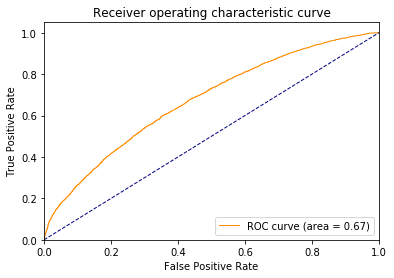

In [14]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()